In [1]:
%load_ext cython
%matplotlib inline
import sys
sys.path.append('/home/bram/ANTS')
sys.path.append('/home/bram/ANTS/entropy')
for p in sys.path:
    print(p)


/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages/IPython/extensions
/home/bram/.ipython
/home/bram/ANTS
/home/bram/ANTS/entropy


In [40]:
%%cython -a
import numpy as np
import sqlite3
import sys, os
cimport cython
from libc.math cimport exp

cdef class db_controller():
    cdef object db
    cdef bytes pending_qry
    
    def __cinit__(self, str db_path,str db_name):
        " class constructor "
        self.db = sqlite3.connect(db_path+db_name)
        self.init_pending()
        
        
    def print_all(self,bytes qry):
        " Print all results from a select qry "
        cur = self.db.cursor()
        cur.execute(qry.decode("utf-8"))
        rows = cur.fetchall()
        for row in rows:
            print(row)
            
    @cython.boundscheck(False)
    @cython.embedsignature(False)
    @cython.wraparound(False)
    @cython.nonecheck(False)
    @cython.cdivision(True)
    @cython.initializedcheck(False)
    cdef void add_rows(self, bytes qry):
        " add rows to a query "
        self.pending_qry+= qry
        
    cdef void init_pending(self):
        self.pending_qry = b"INSERT INTO sim(ID) VALUES "

cdef str path = '/home/bram/ANTS/cythonic/database/'
cdef str db = 'stigmergy.db'
cdef bytes qry = b'SELECT * FROM sim'
cdef bytes str_a = b'a'
cdef bytes str_b = b'b'

cdef db_controller db_handler = db_controller(path,db)
db_handler.print_all(qry)
db_handler.add_rows(b"(1,2,3)")
print(db_handler.pending_qry)

cdef bytes str_c
str_c = str_a+str_b

cdef double[10] vec = np.random.rand(10)
cdef struct xyz:
    double[10] noize
cdef xyz X
X.noize = vec

print(X)


b'INSERT INTO sim(ID) VALUES (1,2,3)'
{'noize': [0.2250033547735666, 0.9384256085011725, 0.29052878136022386, 0.4023469460621243, 0.9615395292908236, 0.458123979966678, 0.5957871731478717, 0.6794028579504037, 0.42340328527614324, 0.5518005545618154]}


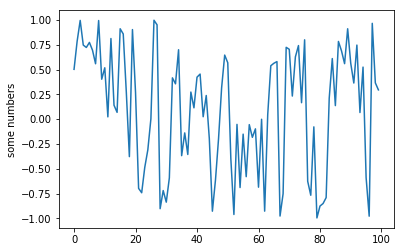

In [91]:
%%cython -a
# distutils: language = c++

from libcpp.vector cimport vector
from libc.math cimport exp as cexp

import numpy as np

cdef vector[double] noise
cdef unsigned int n = 100
cdef str noise_type = 'telegraph'

cdef vector[double] telegraph_noise(unsigned int sz,double dt, double beta):
    cdef double time = 0., t_hop = 0.
    cdef vector[double] output
    cdef double sgn
    for i in range(sz):
        if time >= t_hop:
            time = 0
            t_hop =1-np.exp(-beta*np.random.rand()) 
            sgn  = <double> np.sign(np.random.randn())
        time +=dt
        output.push_back(sgn*0.5+np.random.rand()-.5)
    return output

if noise_type == 'white':
    " stream of white gaussian noise "
    for element in np.random.normal(0,1,n):
        noise.push_back(element)
elif noise_type == 'uniform':
    " stream of uniformly distributed noise from U(-1,1) "
    for element in 2*(np.random.rand(n)-.5):
        noise.push_back(element)
elif noise_type == 'telegraph':
    " telegraphic noise process bounded between [-1,1] "
    noise = telegraph_noise(n, dt = .25, beta = 2)
cdef vector[double] time
for element in np.arange(0,n,1,dtype = np.float_):
    time.push_back(element)
    
cdef struct xy:
    vector[double] x
    vector[double] y
    
cdef xy pair
pair.x = time
pair.y = noise
import matplotlib.pyplot as plt
plt.plot(pair.x,pair.y)
plt.ylabel('some numbers')
plt.show()
        
